<a href="https://colab.research.google.com/github/fotisthemel/files/blob/master/rnn_av_dikomas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/covid_shared/
%pwd

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1QQ0s69LMhGmIpnltBC8vwsYYJ3ixAL7T/covid_shared


'/content/gdrive/.shortcut-targets-by-id/1QQ0s69LMhGmIpnltBC8vwsYYJ3ixAL7T/covid_shared'

seed = 0
best_epoch = 5
min_val = [4.47553566]
seed = 1
best_epoch = 7
min_val = [2.45954339]
seed = 2
best_epoch = 7
min_val = [2.23480931]
seed = 3
best_epoch = 8
min_val = [3.81438452]
seed = 4
best_epoch = 10
min_val = [2.73283194]
seed = 5
best_epoch = 6
min_val = [2.99133245]
seed = 6
best_epoch = 8
min_val = [2.62874385]
seed = 7
best_epoch = 8
min_val = [3.10528146]
seed = 8
best_epoch = 10
min_val = [3.10977795]
seed = 9
best_epoch = 8
min_val = [2.40842877]
MAE mean train=  272.3716308353317
MAE mean val=  311.98616159332056
MAE mean test=  390.59943567487664
R2 mean train=  0.7735257805238034
R2_mean val=  0.445905873822666
R2 mean test=  0.8102243332609683
Standard Deviation MAE train 59.484849923065994
Standard Deviation MAE val 34.664300293932854
Standard Deviation MAE test 80.58624576361474
Standard Deviation R2 train 0.10819677302295051
Standard Deviation R2 val 0.12127727194633377
Standard Deviation R2 test 0.0731653779026605
mae_train =  [438.2842181799157, 225.179656

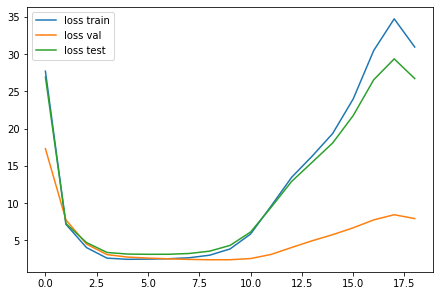

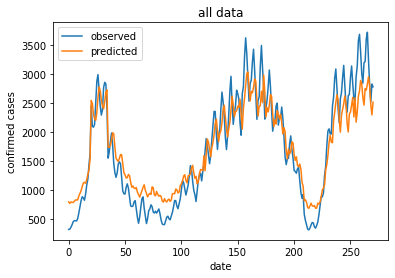

In [ ]:
from pandas import DataFrame
from pandas import concat
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import special_ortho_group
import matplotlib.pyplot as plt
from numpy import random
from sklearn import preprocessing
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

data = pd.read_excel(r'owid-covid-data.xlsx')
dt = data.loc[(data['iso_code']=='GRC')]
new_cases = dt[['new_cases']]
tests = dt[['new_tests']]
rolling = new_cases.rolling(window=4)
cases_mean = rolling.mean()
cases_mean.loc[:,'new_cases'] = cases_mean.values
cases_mean = tests.assign(cases_mean=cases_mean.values)
values = cases_mean.values
values = values.astype('float32') 
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

days_back = 5
n_features = 2
reframed = series_to_supervised(values, days_back, 1)
reframed = reframed[110:]
reframed.drop(reframed.columns[[10]], axis=1, inplace=True)
y=reframed.loc[:,'var2(t)']
reframed.drop(reframed.columns[[10]], axis=1, inplace=True)
x =reframed
x =x.values
y=y.values

trainX, testX, trainY, testY  = train_test_split(
    x , y, test_size=70,shuffle = False)

trainX, valX, trainY, valY  = train_test_split(
    trainX , trainY , test_size=70,shuffle = False)

scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
sc_trainX = scaler.fit_transform(trainX)
sc_valX = scaler.transform(valX)
sc_testX = scaler.transform(testX)

trainXb = np.ones((trainX.shape[0], trainX.shape[1]+1))
trainXb[:,:-1] = trainX
trainX = trainXb
valXb = np.ones((valX.shape[0], valX.shape[1]+1))
valXb[:,:-1] = valX
valX = valXb
testXb = np.ones((testX.shape[0], testX.shape[1]+1))
testXb[:,:-1] = testX
testX = testXb

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
valX = np.reshape(valX, (valX.shape[0], valX.shape[1],1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))

sc_trainXb = np.zeros((sc_trainX.shape[0],sc_trainX.shape[1]+1))
sc_trainXb[:,:-1] = sc_trainX
sc_trainX = sc_trainXb
sc_valXb = np.zeros((sc_valX.shape[0], sc_valX.shape[1]+1))
sc_valXb[:,:-1] = sc_valX
sc_valX = sc_valXb
sc_testXb = np.zeros((sc_testX.shape[0], sc_testX.shape[1]+1))
sc_testXb[:,:-1] = sc_testX
sc_testX = sc_testXb


sc_valX = np.reshape(sc_valX, (sc_valX.shape[0], sc_trainX.shape[1],1))
sc_testX = np.reshape(sc_testX, (sc_testX.shape[0], sc_testX.shape[1],1))
sc_trainX = np.reshape(sc_trainX, (sc_trainX.shape[0], sc_trainX.shape[1],1))

trainY = np.reshape(trainY, (trainY.shape[0], 1))
valY = np.reshape(valY, (valY.shape[0] ,1))
testY = np.reshape(testY, (testY.shape[0],  1))

scalerY = preprocessing.MinMaxScaler(feature_range=(-1,1))
sc_trainY = scalerY.fit_transform(trainY)
sc_valY = scalerY.transform(valY)
sc_testY = scalerY.transform(testY)

# build RNN
class RNNNumpy:

    def __init__(self, seq_len, output_dim=1, hidden_dim=10, bptt_truncate=4):
        # Assign instance variables
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        
        
        
        self.U = np.random.uniform(-np.sqrt(1. / seq_len), np.sqrt(1. / seq_len), (hidden_dim, seq_len))
        self.W = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (hidden_dim, hidden_dim))
        self.V = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), (output_dim, hidden_dim))

    def forward_propagation(self, x):  # input training example
        # The total number of time steps
        T = len(x)
        # During forward propagation we save all hidden states in s because need them later.
        # We add one additional element for the initial hidden, which we set to 0
        s = np.zeros((T, self.hidden_dim))
        s[-1] = np.zeros(self.hidden_dim)
        # The outputs at each time step. Again, we save them for later.
        o = np.zeros((T, 1))
        # For each time step...
        for t in np.arange(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            s[t] = np.tanh(self.U.dot(new_input) + self.W.dot(s[t - 1]).reshape(-1, 1)).reshape(1, -1)
            # print(s)
            o[t] = self.V.dot(s[t])
        return [o, s]

    def predict(self, x):  # input training example
        # Perform forward propagation and return the output at time T
        o, s = self.forward_propagation(x)
        return o[-1]

    def calculate_total_loss(self, x, y):  # input dataset
        L = 0
        # For each training example...
        for i in np.arange(x.shape[0]):
            y_hat = self.predict(x[i])
            L += 0.5 * (y_hat - y[i]) ** 2
        return L

    def calculate_loss(self, x, y):
        # Divide the total loss by the number of training examples OFF
        1
        return self.calculate_total_loss(x, y)

    def bptt(self, x, y):  # input training example
        T = len(x)
        # Perform forward propagation
        o, s = self.forward_propagation(x)
        # We accumulate the gradients in these variables
        dLdU = np.zeros(self.U.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        delta_o = o  # derivative wrt o_t dL/dyhat
        for t in np.arange(T - 1):
            delta_o[t] -= x[t + 1]
        delta_o[-1] -= y
        # For each output backwards...
        for t in np.arange(T)[::-1]:
            dLdV += np.outer(delta_o[t], s[t].T)
            # Initial delta calculation
            # delta_t = dL/dyhat * dyhat/ds * ds/dW @t
            delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))  # 1 - s^2 derivative of tanh
            # Backpropagation through time (for at most self.bptt_truncate steps)
            for bptt_step in np.arange(max(0, t - self.bptt_truncate), t + 1)[::-1]:
                dLdW += np.outer(delta_t, s[bptt_step - 1])

                new_input = np.zeros(x.shape)
                new_input[bptt_step] = x[bptt_step]
                dLdU += np.outer(delta_t, new_input)
                # dLdU[:,x[bptt_step]] += delta_t
                # Update delta for next step
                delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step - 1] ** 2)
        return [dLdU, dLdV, dLdW]

    def sgd_step(self, x, y, learning_rate):  # input training example
        # Calculate the gradients
        dLdU, dLdV, dLdW = self.bptt(x, y)
        # Change parameters according to gradients and learning rate
        self.U -= learning_rate * dLdU
        self.V -= learning_rate * dLdV
        self.W -= learning_rate * dLdW
        return
        # clip derivatives.. ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Outer SGD Loop
# - model: The RNN model instance
# - X_train: The training data set
# - y_train: The training data labels
# - learning_rate: Initial learning rate for SGD
# - nepoch: Number of times to iterate through the complete dataset
def train_with_sgd(model, X_train, y_train, x_test, y_test, x_val, y_val, sc_trainx, sc_valx, sc_testx, sc_trainy,
                   sc_valy, sc_testy, learning_rate=0.005, nepoch=1000):
    # We keep track of the losses so we can plot them later
    losses_train = []
    preds_train = []
    losses_val = []
    iter_no_change = 0
    min_val = float('inf')
    preds_val = []
    losses_test = []
    preds_test = []
    #print("%8s  %8s %8s %8s" % (("train"),  ("val")  ,("test") , "epoch"))
    for epoch in range(nepoch):

        for i in range(len(y_train)):  # iterate over all our training examples
            preds_train.append(scalerY.inverse_transform(model.predict(sc_trainx[i]).reshape(1, 1)))
        loss_train = model.calculate_loss(sc_trainx, sc_trainy)
        losses_train.append(loss_train)

        for i in range(len(y_val)):
            preds_val.append(scalerY.inverse_transform(model.predict(sc_valx[i]).reshape(1, 1)))
        loss_val = model.calculate_loss(sc_valx, sc_valy)
        losses_val.append(loss_val)

        if min(losses_val) < min_val:
            iter_no_change = 0
            min_val = min(losses_val)
            best_epoch = epoch
        else:
            iter_no_change = iter_no_change + 1

        for i in range(len(y_test)):
            preds_test.append(scalerY.inverse_transform(model.predict(sc_testx[i]).reshape(1, 1)))
        loss_test = model.calculate_loss(sc_testx, sc_testy)
        losses_test.append(loss_test)

        #print("%8.4f  %8.4f %8.4f %4d" % ((loss_train) , (loss_val) , (loss_test) , epoch))

        # For each training example...
        for i in range(len(y_train)):
            # One SGD step
            model.sgd_step(sc_trainx[i], sc_trainy[i], learning_rate)
        if iter_no_change >= 10:
            #print("iter_no_change = ", iter_no_change)
            print("best_epoch =", best_epoch)
            print("min_val =", min_val)
            break
    return [preds_train, preds_val, preds_test, losses_train, losses_val, losses_test, best_epoch]


mae_train = []
mae_val = []
mae_test = []

r2_train = []
r2_val = []
r2_test = []

seed_range = 10

for i in range (seed_range):
 np.random.seed(i)
 print("seed =", i)
 seq_length = trainX.shape[1]
 hidden_dim = 10
 output_dim = 1
 bptt_truncate = 4
# Train on a small subset of the data to see what happens
 model = RNNNumpy(seq_len=seq_length, hidden_dim=30,bptt_truncate=5)

 [preds_train, preds_val, preds_test, losses_train,losses_val,losses_test,best_epoch] = train_with_sgd(model, trainX, trainY, testX, testY ,valX, valY, sc_trainX,sc_valX,sc_testX,sc_trainY,sc_valY,sc_testY, nepoch=100)


 preds_train = np.concatenate(preds_train, axis=0)
 preds_train = preds_train.reshape(-1, 1)
 preds_test = np.concatenate(preds_test, axis=0)
 preds_test = preds_test.reshape(-1, 1)
 preds_val = np.concatenate(preds_val, axis=0)
 preds_val = preds_val.reshape(-1, 1)

 preds_train_best_epoch = preds_train[trainX.shape[0]*best_epoch:trainX.shape[0]*(best_epoch+1)]
 preds_val_best_epoch = preds_val[valX.shape[0]*best_epoch:valX.shape[0]*(best_epoch+1)]
 preds_test_best_epoch = preds_test[testX.shape[0]*best_epoch:testX.shape[0]*(best_epoch+1)]



 mae_val.append(mean_absolute_error(valY, preds_val_best_epoch))
 mae_train.append(mean_absolute_error(trainY, preds_train_best_epoch))
 mae_test.append(mean_absolute_error(testY, preds_test_best_epoch))

 r2_train.append(r2_score(trainY, preds_train_best_epoch))
 r2_val.append(r2_score(valY, preds_val_best_epoch))
 r2_test.append(r2_score(testY, preds_test_best_epoch))

print("MAE mean train= ", sum(mae_train) / seed_range)
print("MAE mean val= ", sum(mae_val) / seed_range)
print("MAE mean test= ", sum(mae_test) / seed_range)
print("R2 mean train= ", sum(r2_train) / seed_range)
print("R2_mean val= ", sum(r2_val) / seed_range)
print("R2 mean test= ", sum(r2_test) / seed_range)
print("Standard Deviation MAE train", np.std(mae_train))
print("Standard Deviation MAE val", np.std(mae_val))
print("Standard Deviation MAE test", np.std(mae_test))
print("Standard Deviation R2 train", np.std(r2_train))
print("Standard Deviation R2 val", np.std(r2_val))
print("Standard Deviation R2 test", np.std(r2_test))
print("mae_train = ", mae_train, "mae_val = ", mae_val, "mae_test =  ", mae_test)
print("r2_train = ", r2_train, "r2_val = ", r2_val, "r2_test =  ", r2_test)

# losses plot
fig, ax = plt.subplots(constrained_layout=True)
plt.plot(losses_train, label='loss train')
plt.plot(losses_val, label='loss val')
plt.plot(losses_test, label='loss test')
ax.legend()
plt.show()

# prediction - observed plot
preds_all = np.concatenate([preds_train_best_epoch,preds_val_best_epoch ,preds_test_best_epoch], axis=0)
Y = np.concatenate([trainY, valY ,testY], axis=0)

fig, ax1 = plt.subplots()
plt.plot(Y, label='observed', linestyle='solid')
plt.plot(preds_all[:, 0], label='predicted', linestyle='solid' )
ax1.set_title('all data')
ax1.set_xlabel('date')
ax1.set_ylabel('confirmed cases')

ax1.legend()
plt.show()


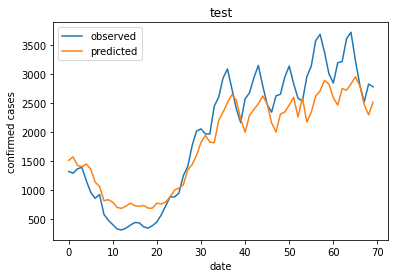

In [ ]:
fig, ax1 = plt.subplots()
plt.plot(testY, label='observed', linestyle='solid')
plt.plot(preds_test_best_epoch[:, 0], label='predicted', linestyle='solid' )
ax1.set_title('test')
ax1.set_xlabel('date')
ax1.set_ylabel('confirmed cases')

ax1.legend()
plt.show()
